# Oxnet Science Robot Navigation Data Processing Solutions

Imports

In [1]:
import numpy as np
import pandas as pd
from scipy.stats import norm
import matplotlib.pyplot as plt
import math

plt.style.use(['science','notebook']) # pip install scienceplots

## Excercises 1 - 4 

1. Print out the edges with the maximum and minimum number of visits.
1. Plot a histogram with the 20 fewest datapoints.
1. Determine the mean, median, and mode number of nav stats per edge.
1. Adapt the histograph above so that each bar has a green part for the count of successful navigation actions, and a red part for a count of the unsuccessful ones. You can use the `status_bin` field for this.

Get the data into pandas dataframes

In [2]:
edges = pd.read_csv('../data/tsc_y3_nav_stats.csv',usecols=['edge_id'])
edges['count'] = 1
edges = edges.groupby(['edge_id']).sum().sort_values(by=['count'], ascending=False).reset_index()

edges_bins = pd.read_csv('../data/tsc_y3_nav_stats.csv', usecols=['edge_id', 'status_bin'])
edges_bins['count']=1
edges_bins = edges_bins.groupby(['edge_id']).sum().sort_values(by=['count'],ascending=False).reset_index()

### Task 1

In [3]:
print(f"Node with the maximum number of visits: {edges.head(1)['edge_id'].to_string(index=False)}")
print(f"Node with the minimum number of visits: {edges.tail(1)['edge_id'].to_string(index=False)}")

Node with the maximum number of visits: SuppLocker13_SuppLocker14
Node with the minimum number of visits: Supp-TransWP2_Supp-TransWP1


### Task 2

<Figure size 576x432 with 0 Axes>

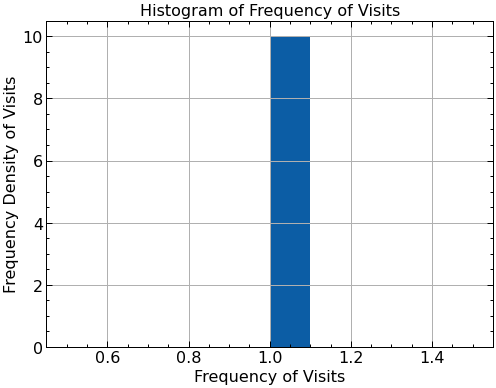

<Figure size 576x432 with 0 Axes>

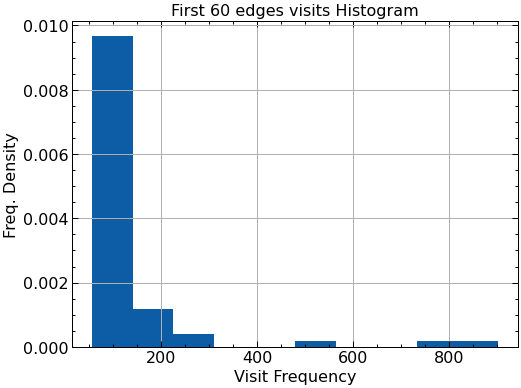

In [4]:
plt.figure()
plot = edges.tail(20).hist(density=True) # very boring as last 20 are all ones
plt.xlabel('Frequency of Visits')
plt.ylabel('Frequency Density of Visits')
plt.title('Histogram of Frequency of Visits')
plt.show()

plt.figure()
edges.head(60).hist(density=True)
plt.xlabel('Visit Frequency')
plt.ylabel('Freq. Density')
plt.title('First 60 edges visits Histogram')
plt.show()

### Task 3

In [5]:
print(f"Mean Visits Per node: {math.floor(edges['count'].mean())}")
print(f"Median Visits Per node: {math.floor(edges['count'].median())}")
print(f"Modal Visits Per node: {math.floor(edges['count'].mode())}")

Mean Visits Per node: 28
Median Visits Per node: 7
Modal Visits Per node: 1


### Task 4

<Figure size 576x432 with 0 Axes>

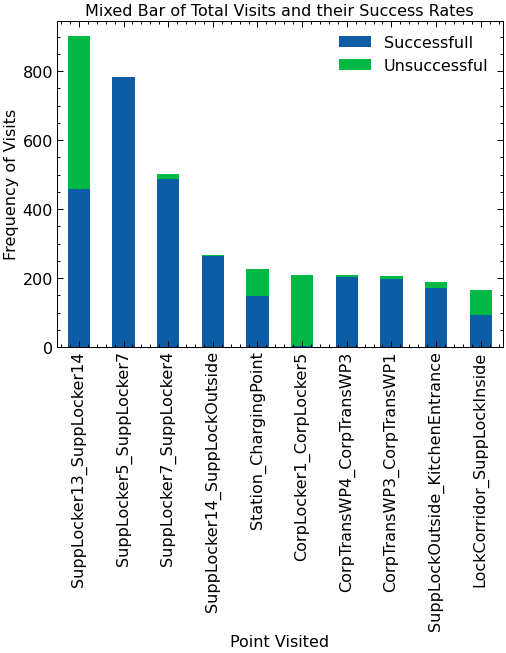

In [6]:
plt.figure()
edges_bins['count'] = edges_bins['count'] - edges_bins['status_bin']
edges_bins.head(10).plot.bar(x='edge_id', stacked=True)
plt.ylabel('Frequency of Visits')
plt.xlabel('Point Visited')
plt.legend(['Successfull', 'Unsuccessful'])
plt.title('Mixed Bar of Total Visits and their Success Rates')
plt.show()

# Parameter Estimation

Generate Dataframe for edge data (without the time - just for probability estimation)

In [7]:
edges = pd.read_csv('../data/tsc_y3_nav_stats.csv', usecols=['edge_id', 'status_bin'])
edges['count']=1
edges = edges.groupby(['edge_id']).sum().sort_values(by=['count'],ascending=False).reset_index()

### Function to get the probability of a single edge

In [8]:
selected = 'SuppLockOutside_KitchenEntrance'
rows = edges[edges['edge_id'] == selected]

def est_succ_prob(rows):
    return (rows['status_bin'] / rows['count']).round(2)
    
est_succ_prob(rows)

8    0.91
dtype: float64

### Function for probability of multiple edges

In [9]:
edges['prob'] = edges['status_bin'] / edges['count']

In [10]:
print(f"Highest Probability of success: {edges.iloc[edges['prob'].idxmax()]['edge_id']}")
print(f"Lowest Probability of success: {edges.iloc[edges['prob'].idxmin()]['edge_id']}")

Highest Probability of success: CorpActRec2_CorpActRec3
Lowest Probability of success: SuppLocker15_SuppTransWP2


### Histogram of the probability distribution of the data

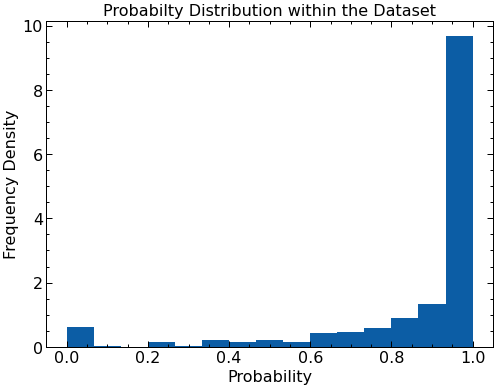

In [11]:
plt.figure()
edges['prob'].plot.hist(density=True, bins=15)
plt.xlabel('Probability')
plt.ylabel('Frequency Density')
plt.title('Probabilty Distribution within the Dataset')
plt.show()

## Edge Duration Estimation

Generate Dataframe for edge data with Duration Included

In [12]:
edges = pd.read_csv('../data/tsc_y3_nav_stats.csv', usecols=['edge_id', 'status_bin','operation_time', 'date_started'])

Function to get variance ($\sigma^2$) and mean ($\bar{x}$) for a specific edge (operation time)

In [13]:
selected = 'SuppLockOutside_KitchenEntrance'
rows = edges[edges['edge_id'] == selected]

def est_dur_par(rows):
    return [(rows['operation_time'].std()**2).round(2),rows['operation_time'].mean().round(2)]

values = est_dur_par(rows)

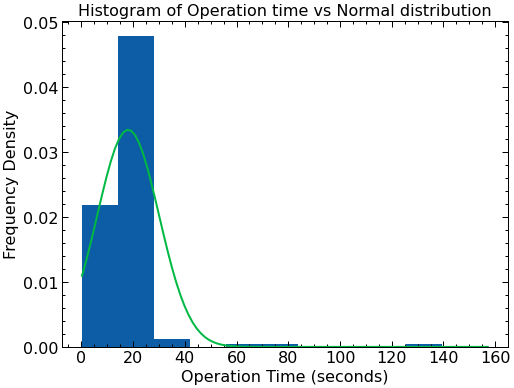

In [14]:
#only for the point SuppLockOutside_KitchenEntrance as shown in the orignal notebook
plt.figure()
rows['operation_time'].plot.hist(density=True)
mu, std = norm.fit(rows['operation_time']) # scipy are the same as the ones from pandas
x = np.linspace(edges['operation_time'].min(), edges['operation_time'].max(), 100)
p = norm.pdf(x, mu, std)
plt.plot(x,p)
plt.xlabel('Operation Time (seconds)')
plt.ylabel('Frequency Density')
plt.title('Histogram of Operation time vs Normal distribution')
plt.show()

### Single Edge IID

Generate dataframe

In [15]:
edges = pd.read_csv('../data/tsc_y3_nav_stats.csv', usecols=['edge_id', 'status_bin','operation_time', 'date_started'])

In [16]:
selected = 'SuppLockOutside_KitchenEntrance'
rows = edges[edges['edge_id'] == selected]
rows_succ = rows[rows['status_bin'] == 1]
rows_fail = rows[rows['status_bin'] == 0]

Normal Distributions of succesful vs failed visits , again only for the point  SuppLockOutside_KitchenEntrance

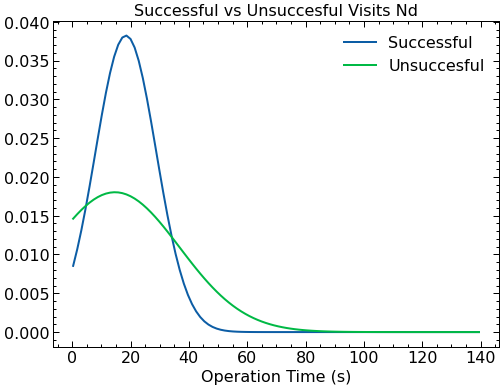

In [17]:
mu_s, std_s = norm.fit(rows_succ['operation_time'])
mu_f, std_f = norm.fit(rows_fail['operation_time'])
x_axis = np.linspace(rows['operation_time'].min(), rows['operation_time'].max(), 100)

plt.figure()
plt.plot(x_axis, norm.pdf(x_axis, mu_s, std_s))
plt.plot(x_axis, norm.pdf(x_axis, mu_f, std_f))
plt.legend(['Successful', 'Unsuccesful'])
plt.xlabel('Operation Time (s)')
plt.title('Successful vs Unsuccesful Visits Nd')
plt.show()

### Multiple Edges

$E(X)$ is the same as the mean ($\bar x$)

Most Uncertain is the one with the highest standard deviation

If you print() one of the df some standard deviations will contain NaN because they only had one data point therefore no deviations

In [18]:
edges = pd.read_csv('../data/tsc_y3_nav_stats.csv', usecols=['edge_id', 'status_bin','operation_time'])

In [19]:
succ  = edges[edges['status_bin'] == 1]
fail = edges[edges['status_bin'] == 0]

succ = succ.groupby('edge_id')['operation_time'].agg(mean='mean', std='std')
fail = fail.groupby('edge_id')['operation_time'].agg(mean='mean', std='std')

print(f"Lowest Duration Succesful Edge: {succ['mean'].idxmin()} at {succ['mean'].min().round(2)}s")
print(f"Most uncertain failed edge: {fail['std'].idxmax()} at {fail['std'].max().round(2)} deviation")

Lowest Duration Succesful Edge: WayPoint20_WayPoint18 at 4.55s
Most uncertain failed edge: SuppLocker2_SuppTransWP1 at 78.56 deviation


### Removing Outliers from the data

will remove all datapoints more than 3 standard deviations from the mean

In [20]:
succ2 = succ
fail2 = fail


# remove all above and below 3 std from the mean
succ2 = succ2.drop(succ2.index[succ2['mean'] < (mu_s - 3*std_s)])
succ2 = succ2.drop(succ2.index[succ2['mean'] > (mu_s + 3*std_s)])

fail = fail2.drop(fail2.index[fail2['mean'] < (mu_f - 3*std_f)])
fail2 = fail2.drop(fail2.index[fail2['mean'] > (mu_f + 3*std_f)])

print(f"Lowest Duration Succesful Edge: {succ2['mean'].idxmin()} at {succ2['mean'].min().round(2)}s")
print(f"Most uncertain failed edge: {fail2['std'].idxmax()} at {fail2['std'].max().round(2)} deviation")

Lowest Duration Succesful Edge: WayPoint20_WayPoint18 at 4.55s
Most uncertain failed edge: SuppLocker2_SuppTransWP1 at 78.56 deviation
